### #5

Kaggle competition: https://www.kaggle.com/competitions/playground-series-s5e1/

Entry by Robin P.M. Kras

In [15]:
import pandas as pd

tr = pd.read_csv("train.csv")
te = pd.read_csv("test.csv")

### Problem Understanding

This competition is about:

Your Goal: The objective of this challenge is to forecast sticker sales in different countries. "At Kaggle, we take stickers seriously!"™️

"For this challenge, you will be predicting multiple years worth of sales for various Kaggle-branded stickers from different fictitious stores in different (real!) countries. This dataset is completely synthetic, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc."

This problem seems rather straightforward.

In [16]:
tr.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [17]:
print(f"Num unique countries:", tr['country'].nunique())
print(f"Num unique stores:", tr['store'].nunique())
print(f"Num unique stickers:", tr['product'].nunique())

Num unique countries: 6
Num unique stores: 3
Num unique stickers: 5


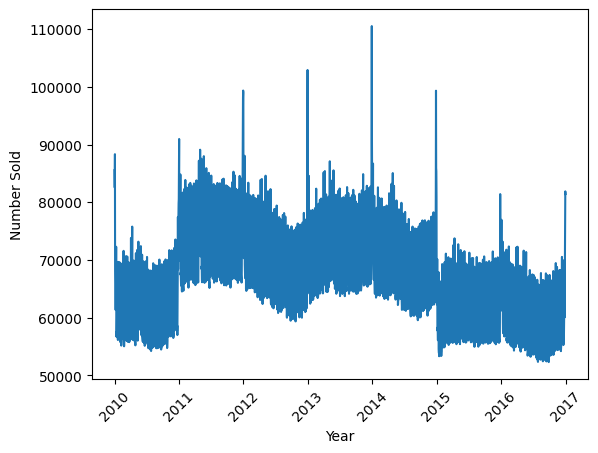

In [18]:
import matplotlib.pyplot as plt

tr_copy = tr

tr_copy['date'] = pd.to_datetime(tr['date'])

yearly_sales = tr_copy.groupby('date')['num_sold'].sum().reset_index()

plt.plot(yearly_sales['date'], yearly_sales['num_sold'])
plt.xlabel('Year')
plt.ylabel('Number Sold')
plt.xticks(rotation=45)
plt.show()

That is already a little better.

In [19]:
print(f"Train set, null count: \n{tr.isnull().sum()}")
print("\n")
print(f"Test set, null count: \n{te.isnull().sum()}")

Train set, null count: 
id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64


Test set, null count: 
id         0
date       0
country    0
store      0
product    0
dtype: int64


In [20]:
tr['prev_day'] = tr['num_sold'].shift(1)
tr['next_day'] = tr['num_sold'].shift(-1)

tr['num_sold'] = tr['num_sold'].fillna((tr['prev_day'] + tr['next_day']) / 2)
tr['num_sold'] = tr['num_sold'].fillna(0)

tr = tr.drop(['prev_day', 'next_day'], axis=1)

tr = tr.drop(columns=["date"])
te = te.drop(columns=["date"])

In [21]:
tr.head()

,id,country,store,product,num_sold
0,0,Canada,Discount Stickers,Holographic Goose,0.0
1,1,Canada,Discount Stickers,Kaggle,973.0
2,2,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,Canada,Discount Stickers,Kerneler,423.0
4,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [22]:
te.head()

,id,country,store,product
0,230130,Canada,Discount Stickers,Holographic Goose
1,230131,Canada,Discount Stickers,Kaggle
2,230132,Canada,Discount Stickers,Kaggle Tiers
3,230133,Canada,Discount Stickers,Kerneler
4,230134,Canada,Discount Stickers,Kerneler Dark Mode


In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

tr['country'] = le.fit_transform(tr['country'])
tr['store'] = le.fit_transform(tr['store'])
tr['product'] = le.fit_transform(tr['product'])

te['country'] = le.fit_transform(te['country'])
te['store'] = le.fit_transform(te['store'])
te['product'] = le.fit_transform(te['product'])

In [24]:
te.head()

,id,country,store,product
0,230130,0,0,0
1,230131,0,0,1
2,230132,0,0,2
3,230133,0,0,3
4,230134,0,0,4


### Model Selection

In [ ]:
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_percentage_error

Your submission was successfully saved!


In [ ]:
features = ["country", "store", "product"]

y = tr['num_sold']  

X = pd.get_dummies(tr[features])
X_test = pd.get_dummies(te[features])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xg.XGBRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

output = pd.DataFrame({'id': te.id, 'num_sold': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [37]:
import numpy as np

val_predictions = model.predict(X_val)

mape = np.mean(np.abs((y_val - val_predictions) / y_val)) * 100
print(f"Validation MAPE: {mape:.2f}%")

Validation MAPE: 16.94%


100%|===================| 45998/46026 [03:15<00:00]        

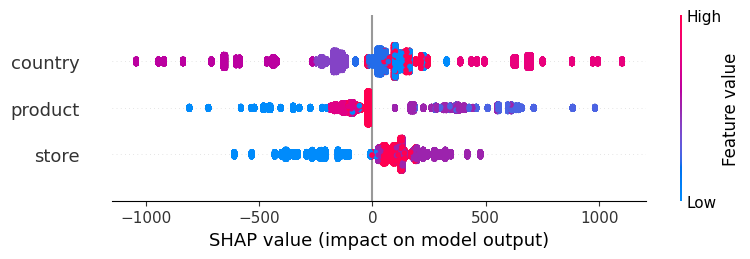

In [38]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val) 

shap.summary_plot(shap_values, X_val)